In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sani84_glasmiccai2015_gland_segmentation_path = kagglehub.dataset_download('sani84/glasmiccai2015-gland-segmentation')

print('Data source import complete.')


100%|██████████| 172M/172M [00:03<00:00, 56.5MB/s]

Extracting files...


Data source import complete.


In [ ]:
!pip install gdown

In [1]:
#!ls
#/kaggle/input/notebook93ac64e260
#/kaggle/input/osf-gland-seg
#!ls /kaggle/input/osf-gland-seg/public_data/trainData/DSS-2018-28-079_5
#1AWAJHlKv-8uWBCWZGJzX0bJe6FKDr4Eq
#!gdown --id 1AWAJHlKv-8uWBCWZGJzX0bJe6FKDr4Eq
#!gdown --id 13hwIRHyDTlcrr2d43O1R1QsPyQDyvYgN
!gdown --id 1DF8xYPgmV1msidCjIqx0HtN6ON7RfrsN
#!ls
checkpoint = '45_data_mod_res34.pth'

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1DF8xYPgmV1msidCjIqx0HtN6ON7RfrsN

but Gdown can't. Please check connections and permissions.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#https://github.com/twpkevin06222/Gland-Segmentation
#!ls /kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import yaml
import random
from pathlib import Path


IMG_SIZE = (IMG_H, IMG_W) = (512,512)

F_DEBUG, F_FULL_DATA = False, False
TRAIN_SIZE = .9 if not F_FULL_DATA else .99
DATA_2015_DIR = '/content/drive/MyDrive/converted_notebooks/GenSelfDiff-HIS-main/GLaS_data/'
OSF_DATA_DIR = '/content/drive/MyDrive/public_data/trainData/'
NPY_DATA_DIR = './npy/'
if not os.path.exists((NPY_DATA_DIR)):
    !mkdir {NPY_DATA_DIR}
    !mkdir {NPY_DATA_DIR}/train
    !mkdir {NPY_DATA_DIR}/val
!ls {NPY_DATA_DIR}
RANDOM_STATE = RANDOM_SEED = 42

train  val


In [4]:
def get_npy_osf(source_dir, dest_dir, new_size=IMG_SIZE, f_save = True, mask_lim=0.1):
    img_save_path_list, anno_save_path_list = [], []
    for img_dir in  os.listdir(source_dir):

        img_anno_dir = os.path.join(source_dir, img_dir)
        img = cv2.imread(img_anno_dir+'/crop.png');
        print(img_dir, os.listdir(img_anno_dir))
        plt.imshow(img)

        mask= json.load(open(img_anno_dir+'/gland_anno.json') )
        anno=[]
        for i in mask:
            coor = mask[i]["coors"];
            coor = [np.asarray(x) for x in coor];
            anno.append(np.asarray(coor));
        mask = np.zeros((img.shape[0],img.shape[1]))
        for a in anno:
            mask=cv2.fillPoly(mask, np.asarray([a]), 1);
        big_h, big_w = img.shape[:2]
        h, w = new_size
        #  new_size < images.shape
        n_splits_h, n_splits_w = (big_h+h-1)//h, (big_w+w-1)//w

        half_h_range = n_splits_h//2+n_splits_h%2
        half_w_range = n_splits_w//2+n_splits_w%2
        for h_idx in range(half_h_range):
            for w_idx in range(half_w_range):
                img_n_pf = '_'+str(h_idx)+'_'+str(w_idx)
                small_img = img[h_idx*h:(h_idx+1)*h, w_idx*w: (w_idx+1)*w, :]
                small_mask = mask[h_idx*h:(h_idx+1)*h, w_idx*w: (w_idx+1)*w]
                small_mask = np.stack([small_mask]*3, axis=-1)
                #print(np.unique(small_mask).sum(), small_mask.shape, small_img.shape, img_n_pf, h_idx*h, (h_idx+1)*h, w_idx*w, (w_idx+1)*w)
                img_path = os.path.join(dest_dir, img_dir+img_n_pf+'.npy')
                anno_path = os.path.join(dest_dir, img_dir+img_n_pf+'_anno.npy')
                #if np.unique(small_mask).sum()!=0.:
                if small_mask.sum()>=mask_lim*h*w:
                    img_save_path_list.append(img_path)
                    anno_save_path_list.append(anno_path)
                    if f_save:
                        np.save(img_path, small_img)
                        np.save(anno_path, small_mask)

        start_h, start_w = h_idx*h + big_h%h, w_idx*w + big_w%w
        for h_idx in range(n_splits_h-half_h_range):
            for w_idx in range(n_splits_w-half_w_range):
                img_n_pf = '_'+str(h_idx+half_h_range)+'_'+str(w_idx+half_w_range)
                small_img = img[start_h+h_idx*h:start_h+(h_idx+1)*h, start_w+w_idx*w:start_w+(w_idx+1)*w, :]
                small_mask = mask[start_h+h_idx*h:start_h+(h_idx+1)*h, start_w+w_idx*w:start_w+(w_idx+1)*w]
                small_mask = np.stack([small_mask]*3, axis=-1)
                #print(small_mask.shape, small_img.shape, img_n_pf, start_h+h_idx*h, start_h+(h_idx+1)*h, start_w+w_idx*w, start_w+(w_idx+1)*w)
                img_path = os.path.join(dest_dir, img_dir+img_n_pf+'.npy')
                anno_path = os.path.join(dest_dir, img_dir+img_n_pf+'_anno.npy')
                #if np.unique(small_mask).sum()!=0.:
                if small_mask.sum()>=mask_lim*h*w:
                    img_save_path_list.append(img_path)
                    anno_save_path_list.append(anno_path)
                    if f_save:
                        np.save(img_path, small_img)
                        np.save(anno_path, small_mask)


        '''
        for cur_h in range(0,big_h,h):
            for cur_w in range(0,big_w,w):
                print(cur_h, cur_h+h, cur_w, cur_w+w)
                next_img = img[cur_h:min(cur_h+h), cur_w:cur_w+w, :]
        '''
        print(img.shape, mask.shape, new_size, n_splits_h, n_splits_w)
        #break
        #break
    pass
    return img_save_path_list, anno_save_path_list
#img_save_path_list_osf, anno_save_path_list_osf = get_npy_osf(OSF_DATA_DIR, NPY_DATA_DIR+'train', f_save=True)
#https://osf.io/9anjy
#len(img_save_path_list_osf)#, anno_save_path_list_osf

In [5]:
'''image_num = 2
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

axes[0].imshow(np.load(img_save_path_list_osf[image_num]))
axes[1].imshow(np.load(anno_save_path_list_osf[image_num]))
'''

'image_num = 2\nfig, axes = plt.subplots(1, 2, figsize=(12, 6))\nfig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)\n\naxes[0].imshow(np.load(img_save_path_list_osf[image_num]))\naxes[1].imshow(np.load(anno_save_path_list_osf[image_num]))\n'

In [6]:
def get_npy_osf_mod(source_dir, dest_dir, new_size=IMG_SIZE, f_save = True, mask_lim=0.25):
    img_save_path_list, anno_save_path_list = [], []
    for img_dir in  sorted(os.listdir(source_dir)):
        # возможно нужно фильтровать однородные картинки
        img_anno_dir = os.path.join(source_dir, img_dir)
        img = cv2.imread(img_anno_dir+'/crop.png');
        print(img_dir, os.listdir(img_anno_dir))
        #plt.imshow(img)

        mask= json.load(open(img_anno_dir+'/gland_anno.json') )
        anno=[]
        for i in mask:
            coor = mask[i]["coors"];
            coor = [np.asarray(x) for x in coor];
            anno.append(np.asarray(coor));
        mask = np.zeros((img.shape[0],img.shape[1]))
        for a in anno:
            mask=cv2.fillPoly(mask, np.asarray([a]), 1);
        big_h, big_w = img.shape[:2]
        new_size_mul = .33
        h, w = int(new_size[0] * new_size_mul), int(new_size[1] * new_size_mul)
        #  new_size < images.shape
        n_splits_h, n_splits_w = (big_h+h-1)//h, (big_w+w-1)//w

        half_h_range = n_splits_h//2+n_splits_h%2
        half_w_range = n_splits_w//2+n_splits_w%2
        for h_idx in range(half_h_range):
            for w_idx in range(half_w_range):
                img_n_pf = '_'+str(h_idx)+'_'+str(w_idx)
                small_img = img[h_idx*h:(h_idx+1)*h, w_idx*w: (w_idx+1)*w, :]
                small_mask = mask[h_idx*h:(h_idx+1)*h, w_idx*w: (w_idx+1)*w]
                small_mask = np.stack([small_mask]*3, axis=-1)
                #print(np.unique(small_mask).sum(), small_mask.shape, small_img.shape, img_n_pf, h_idx*h, (h_idx+1)*h, w_idx*w, (w_idx+1)*w)
                img_path = os.path.join(dest_dir, img_dir+img_n_pf+'.npy')
                anno_path = os.path.join(dest_dir, img_dir+img_n_pf+'_anno.npy')
                #if np.unique(small_mask).sum()!=0.:
                if small_mask.sum()>=mask_lim*h*w:
                    img_save_path_list.append(img_path)
                    anno_save_path_list.append(anno_path)
                    if f_save:
                        small_img = cv2.resize(small_img, new_size)
                        small_mask = cv2.resize(small_mask, new_size)
                        np.save(img_path, small_img)
                        np.save(anno_path, small_mask)

        start_h, start_w = h_idx*h + big_h%h, w_idx*w + big_w%w
        for h_idx in range(n_splits_h-half_h_range):
            for w_idx in range(n_splits_w-half_w_range):
                img_n_pf = '_'+str(h_idx+half_h_range)+'_'+str(w_idx+half_w_range)
                small_img = img[start_h+h_idx*h:start_h+(h_idx+1)*h, start_w+w_idx*w:start_w+(w_idx+1)*w, :]
                small_mask = mask[start_h+h_idx*h:start_h+(h_idx+1)*h, start_w+w_idx*w:start_w+(w_idx+1)*w]
                small_mask = np.stack([small_mask]*3, axis=-1)
                #print(small_mask.shape, small_img.shape, img_n_pf, start_h+h_idx*h, start_h+(h_idx+1)*h, start_w+w_idx*w, start_w+(w_idx+1)*w)
                img_path = os.path.join(dest_dir, img_dir+img_n_pf+'.npy')
                anno_path = os.path.join(dest_dir, img_dir+img_n_pf+'_anno.npy')
                #if np.unique(small_mask).sum()!=0.:
                if small_mask.sum()>=mask_lim*h*w:
                    img_save_path_list.append(img_path)
                    anno_save_path_list.append(anno_path)
                    if f_save:
                        small_img = cv2.resize(small_img, new_size)
                        small_mask = cv2.resize(small_mask, new_size)
                        np.save(img_path, small_img)
                        np.save(anno_path, small_mask)

        print(img.shape, mask.shape, new_size, n_splits_h, n_splits_w)
        #break
        #break
    pass
    return img_save_path_list, anno_save_path_list
img_save_path_list_osf_mod, anno_save_path_list_osf_mod = get_npy_osf_mod(OSF_DATA_DIR, NPY_DATA_DIR+'train', f_save=True)
len(img_save_path_list_osf_mod)#, anno_save_path_list_osf

DSS-2018-28-002_1 ['gland_anno.json', 'crop.png', 'mucosa_anno.json']
(3364, 3750, 3) (3364, 3750) (512, 512) 21 23
DSS-2018-28-002_2 ['gland_anno.json', 'mucosa_anno.json', 'crop.png']
(4595, 4200, 3) (4595, 4200) (512, 512) 28 25
DSS-2018-28-002_5 ['gland_anno.json', 'mucosa_anno.json', 'crop.png']
(6247, 5190, 3) (6247, 5190) (512, 512) 38 31
DSS-2018-28-005_1 ['mucosa_anno.json', 'gland_anno.json', 'crop.png']
(5554, 4725, 3) (5554, 4725) (512, 512) 34 29
DSS-2018-28-005_3 ['mucosa_anno.json', 'gland_anno.json', 'crop.png']
(5617, 5044, 3) (5617, 5044) (512, 512) 34 31
DSS-2018-28-013_10 ['gland_anno.json', 'mucosa_anno.json', 'crop.png']
(3266, 3114, 3) (3266, 3114) (512, 512) 20 19
DSS-2018-28-013_13 ['crop.png', 'gland_anno.json', 'mucosa_anno.json']
(4704, 4162, 3) (4704, 4162) (512, 512) 28 25
DSS-2018-28-013_a1 ['crop.png', 'mucosa_anno.json', 'gland_anno.json', 'DSS-2018-32-013_15']
(4608, 3800, 3) (4608, 3800) (512, 512) 28 23
DSS-2018-28-016_1 ['crop.png', 'gland_anno.json

879

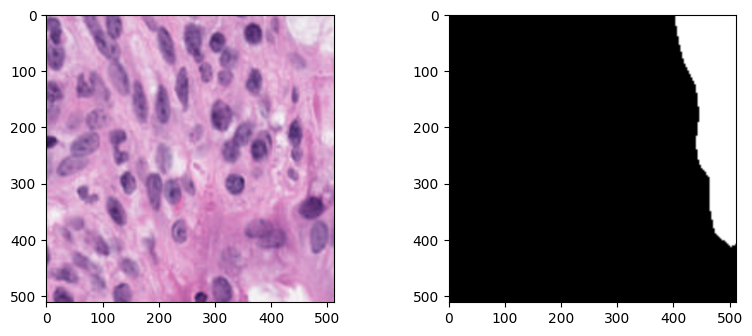

In [7]:
image_num = 2
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

axes[0].imshow(np.load(img_save_path_list_osf_mod[image_num]))
axes[1].imshow(np.load(anno_save_path_list_osf_mod[image_num]))

In [8]:
from sklearn.model_selection import train_test_split
tr_val_data = [f_name.split('.')[0] for f_name in os.listdir(DATA_2015_DIR) if (not 'anno' in f_name) and (f_name.split('.')[1]=='bmp')]
print(len(tr_val_data))
if F_DEBUG: tr_val_data = random.sample(tr_val_data, 20)
#tr_data, val_data = train_test_split(tr_val_data, train_size=TRAIN_SIZE, random_state = RANDOM_STATE)
len(tr_val_data) #, len(tr_data), len(val_data)

165


165

DSS-2018-28-005_1_12_6.npy


<Figure size 600x300 with 0 Axes>

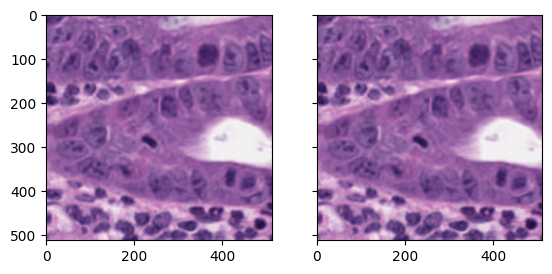

In [9]:

def get_npy(source_dir, dest_dir, f_name_list, new_size=IMG_SIZE, f_save = True):
    #resize TODO crop, padding,
    #print(source_dir, dest_dir, f_name_list)
    img_save_path_list, anno_save_path_list = [], []
    for f_name in f_name_list:
        img_f_name, anno_f_name = f_name + '.bmp', f_name + '_anno.bmp'
        img = cv2.imread(os.path.join(source_dir, img_f_name))
        img = cv2.resize(img, new_size)
        img_path = os.path.join(dest_dir, f_name+'.npy')

        img_save_path_list.append(img_path)
        anno = cv2.imread(os.path.join(source_dir, anno_f_name))
        anno = cv2.resize(anno, new_size)
        anno_thres = np.where(anno>0, 1.0, 0.0)
        anno_path = os.path.join(dest_dir, f_name+'_anno.npy')
        anno_save_path_list.append(anno_path)
        if f_save:
            np.save(img_path, img)
            np.save(anno_path, anno_thres)
        #print(img.shape, anno.shape, anno_thres.shape)
    return img_save_path_list, anno_save_path_list
img_save_path_list, anno_save_path_list = get_npy(DATA_2015_DIR, NPY_DATA_DIR+'train', tr_val_data)
#val_img_save_path_list, _ = get_npy(DATA_2015_DIR, NPY_DATA_DIR+'val', val_data, f_save=False)
#get_npy(DATA_2015_DIR, NPY_DATA_DIR+'train', val_data)
#get_npy(DATA_2015_DIR, NPY_DATA_DIR+'val', val_data)
#!ls {NPY_DATA_DIR+'train'}
#if F_DEBUG:
f_name = os.listdir(NPY_DATA_DIR+'train')[0]
print(f_name)
img = np.load(os.path.join(NPY_DATA_DIR+'train', f_name))
anno = np.load(os.path.join(NPY_DATA_DIR+'train', f_name.split('.')[0]+'.npy'))
plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')#,figsize=(20, 10)
ax[0].imshow(img)
ax[1].imshow(anno)
#  './npy/train/DSS-2018-28-079_1_3_3.npy',

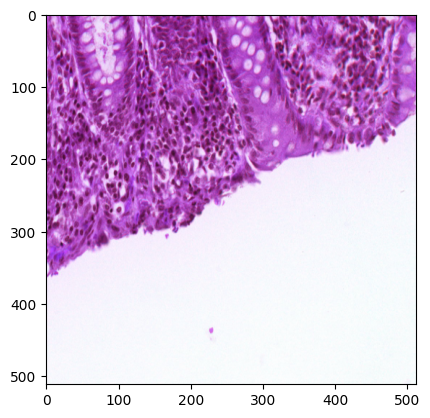

In [10]:
plt.imshow(np.load(img_save_path_list[image_num]))

In [11]:
#len(img_save_path_list), len(anno_save_path_list_osf)

In [12]:
'''#/gt_test_256_192
#!cat /kaggle/input/notebook81642cdbb0/OEEM_resources/glas_seg/train.lst
img_dir = '/kaggle/input/notebook81642cdbb0/OEEM_resources/glas_seg/gt_test_256_192/'
for f_name in os.listdir(img_dir):
    f_path = os.path.join(img_dir, f_name)
    print(f_path)
    if f_name.split('.')[-1]!='png':
        continue
    img = cv2.imread(f_path)
    print(img.shape)
    plt.imshow(img)
    if input()=='q':
        break'''

"#/gt_test_256_192\n#!cat /kaggle/input/notebook81642cdbb0/OEEM_resources/glas_seg/train.lst\nimg_dir = '/kaggle/input/notebook81642cdbb0/OEEM_resources/glas_seg/gt_test_256_192/'\nfor f_name in os.listdir(img_dir):\n    f_path = os.path.join(img_dir, f_name)\n    print(f_path)\n    if f_name.split('.')[-1]!='png':\n        continue\n    img = cv2.imread(f_path)\n    print(img.shape)\n    plt.imshow(img)\n    if input()=='q':\n        break"

In [13]:
img_save_path_list += img_save_path_list_osf_mod#img_save_path_list_osf
anno_save_path_list += anno_save_path_list_osf_mod#anno_save_path_list_osf
print(len(anno_save_path_list), len(img_save_path_list))
#img_save_path_list = [os.path.join(NPY_DATA_DIR+'train',f_name)]
ds = pd.DataFrame({'img_npy': img_save_path_list, 'anno_npy': anno_save_path_list})
ds['fold'] = [0]*len(ds)

tr_data, val_data = train_test_split(ds, train_size=TRAIN_SIZE, random_state = RANDOM_STATE)
print(len(val_data))
ds.loc[val_data.index.values, 'fold']=1
ds.to_csv('data.csv', index=False)
ds = pd.read_csv('data.csv')
ds.head(3)

1044 1044
105


,img_npy,anno_npy,fold
0,./npy/train/testA_12.npy,./npy/train/testA_12_anno.npy,0
1,./npy/train/testA_1.npy,./npy/train/testA_1_anno.npy,0
2,./npy/train/testA_11.npy,./npy/train/testA_11_anno.npy,0


In [14]:
!pip install batchgenerators &> log.txt
!pip install segmentation_models_pytorch &> log.txt
#!pip install torchsummary &> log.txt
#!pip install yamldataclassconfig &> log.txt
#&> log.txt
#&> log.txt

In [15]:
# batch generator by MIC-DKFZ: https://github.com/MIC-DKFZ/batchgenerators
import numpy as np
from batchgenerators.dataloading.data_loader import DataLoader
from batchgenerators.transforms.abstract_transforms import Compose
from batchgenerators.transforms.spatial_transforms import MirrorTransform, SpatialTransform
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, ContrastAugmentationTransform
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform, GaussianBlurTransform
from batchgenerators.augmentations.crop_and_pad_augmentations import crop


def get_split_fold(data):
    """
    If the data set is already split according to folds with indices [0,1,2]
    where:
    train => 0
    testA => 1
    testB => 2
    @param data: csv file where the data sets are stored
    @return: dictionaries of train, testA, testB dictionary
    """
    # return indices of fold data
    train_idx = np.where(data['fold'] == 0)[0]
    testA_idx = np.where(data['fold'] == 1)[0]
    #testB_idx = np.where(data['fold'] == 2)[0]
    testB_idx = np.where(data['fold'] == 1)[0]

    # create dictionary for each data set
    train_ds = {'img_npy': [data['img_npy'].tolist()[i] for i in train_idx],
                'anno_npy': [data['anno_npy'].tolist()[i] for i in train_idx],
                #'patient_id': [data['patient ID'].tolist()[i] for i in train_idx]
                }
    testA_ds = {'img_npy': [data['img_npy'].tolist()[i] for i in testA_idx],
                'anno_npy': [data['anno_npy'].tolist()[i] for i in testA_idx],
                #'patient_id': [data['patient ID'].tolist()[i] for i in testA_idx]
                }
    testB_ds = {'img_npy': [data['img_npy'].tolist()[i] for i in testB_idx],
                'anno_npy': [data['anno_npy'].tolist()[i] for i in testB_idx],
                #'patient_id': [data['patient ID'].tolist()[i] for i in testB_idx]
                }

    return {'train_ds':train_ds, 'testA_ds': testA_ds, 'testB_ds': testB_ds}


def get_train_transform(patch_size, prob=0.5):
    # We now create a list of transforms.
    # These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # the first thing we want to run is the SpatialTransform. It reduces the size of our data to patch_size and thus
    # also reduces the computational cost of all subsequent operations. All subsequent operations do not modify the
    # shape and do not transform spatially, so no border artifacts will be introduced
    # Here we use the new SpatialTransform_2 which uses a new way of parameterizing elastic_deform
    # We use all spatial transformations with a probability of 0.2 per sample. This means that 1 - (1 - 0.1) ** 3 = 27%
    # of samples will be augmented, the rest will just be cropped
    tr_transforms.append(
        SpatialTransform(
            patch_size,
            [i // 2 for i in patch_size],
            do_elastic_deform=True,
            alpha=(0., 300.),
            sigma=(20., 40.),
            do_rotation=True,
            angle_x=(-np.pi/15., np.pi/15.),
            angle_y=(-np.pi/15., np.pi/15.),
            angle_z=(0., 0.),
            do_scale=True,
            scale=(1/1.15, 1.15),
            random_crop=False,
            border_mode_data='constant',
            border_cval_data=0,
            order_data=3,
            p_el_per_sample=prob, p_rot_per_sample=prob, p_scale_per_sample=prob
        )
    )

    # now we mirror along the y-axis
    tr_transforms.append(MirrorTransform(axes=(1,)))

    # brightness transform
    tr_transforms.append(BrightnessMultiplicativeTransform((0.7, 1.5), per_channel=True, p_per_sample=prob))

    # Gaussian Noise
    tr_transforms.append(GaussianNoiseTransform(noise_variance=(0, 0.5), p_per_sample=prob))

    # blurring. Some BraTS cases have very blurry modalities. This can simulate more patients with this problem and
    # thus make the model more robust to it
    tr_transforms.append(GaussianBlurTransform(blur_sigma=(0.5, 2.0), different_sigma_per_channel=True,
                                               p_per_channel=prob, p_per_sample=prob))
    tr_transforms.append(ContrastAugmentationTransform(contrast_range=(0.75, 1.25), p_per_sample=prob))
    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms


class DataLoader(DataLoader):
    def __init__(self, data, batch_size, patch_size, num_threads_in_multithreaded,
                 crop_status=False, crop_type="center",
                 seed_for_shuffle=1234, return_incomplete=False, shuffle=True,
                 infinite=True, margins=(0,0,0)):
        """
        data must be a list of patients as returned by get_list_of_patients (and split by get_split_deterministic)
        patch_size is the spatial size the returned batch will have
        """
        super().__init__(data, batch_size, num_threads_in_multithreaded, seed_for_shuffle, return_incomplete, shuffle,
                         infinite)
        # original patch size with [width, height]
        self.patch_size = patch_size
        self.n_channel = 3
        self.indices = list(range(len(data['img_npy'])))
        self.crop_status = crop_status
        self.crop_type = crop_type
        self.margins = margins

    @staticmethod
    def load_patient(img_path):
        img = np.load(img_path, mmap_mode="r")
        return img

    def generate_train_batch(self):
        # DataLoader has its own methods for selecting what patients to use next, see its Documentation
        idx = self.get_indices()
        gland_img = [self._data['img_npy'][i] for i in idx]
        img_seg = [self._data['anno_npy'][i] for i in idx]
        #patient_id = [self._data['patient_id'][i] for i in idx]
        # initialize empty array for data and seg
        img = np.zeros((len(gland_img), self.n_channel, *self.patch_size), dtype=np.float32)
        seg = np.zeros((len(img_seg), self.n_channel, *self.patch_size), dtype=np.float32)
        # iterate over patients_for_batch and include them in the batch
        for i, (j,k) in enumerate(zip(gland_img, img_seg)):
            img_data = self.load_patient(j)
            seg_data = self.load_patient(k)
            # according to the documentation
            # the input image should use channel first as input
            # hence we use tensor manipulation to convert to channel first
            img_data = np.einsum('hwc->chw', img_data)
            seg_data = np.einsum('hwc->chw', seg_data)
            # now random crop to self.patch_size
            # crop expects the data to be (b, c, x, y, z) but patient_data is (c, x, y, z) so we need to add one
            # dummy dimension in order for it to work (@Todo, could be improved)
            if self.crop_status:
                img_data, seg_data = crop(img_data[None], seg=seg_data[None], crop_size=self.patch_size,
                                    margins=self.margins, crop_type=self.crop_type)
                img[i] = img_data[0]
                seg[i] = seg_data[0]
            else:
                img[i] = img_data
                seg[i] = seg_data
        return {'data': img, 'seg': seg}#, 'patient_id': patient_id}
'''
with open('dataloader.py', 'w') as f:
    f.write(txt)
!ls'''
None

In [16]:
import torch
from torch import nn
from torch import Tensor
#from torchsummary import summary
import torch.nn.functional as F
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"


class SeparableConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int,
                 stride: tuple, kernel_size: tuple = (3, 3),
                 padding: str or int = 'same') -> None:
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))

    def forward(self, x: Tensor) -> Tensor:
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x


class ConvBlock(nn.Module):
    """
    Pre-activation convblock:
    batch norm -> activation -> weights
    """
    def __init__(self, in_channels: int, out_channels: int,
                 stride: tuple = (1, 1), dropout: float = 0.1) -> None:
        super(ConvBlock, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = SeparableConv2d(in_channels, out_channels,
                                    stride=stride)
        self.drop = nn.Dropout2d(dropout, inplace=True)

    def forward(self, x: Tensor) -> Tensor:
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.drop(x)

        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int,
                 kernel_size: tuple = (3, 3)) -> None:
        super(UpBlock, self).__init__()
        self.up = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              padding='same')

    def forward(self, x: Tensor) -> Tensor:
        x = self.up(x)
        x = self.conv(x)

        return x


class UpConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int,
                 kernel_size: tuple = (3, 3)) -> None:
        super(UpConvBlock, self).__init__()
        self.up = UpBlock(in_channels, out_channels, kernel_size)
        self.convblock1 = ConvBlock(out_channels*2, out_channels)
        self.convblock2 = ConvBlock(out_channels, out_channels)

    def forward(self, x: Tensor, enc_feature: Tensor) -> Tensor:
        x = self.up(x)
        x = torch.cat([x, enc_feature], dim=1)
        x = self.convblock1(x)
        x = self.convblock2(x)

        return x


class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int,
                 downsampling: bool = True) -> None:
        super(ResBlock, self).__init__()
        self.downsampling = downsampling
        if self.downsampling:
            self.down_conv = SeparableConv2d(in_channels, out_channels,
                                             stride=(2, 2), padding='valid')
            self.convblock1 = ConvBlock(out_channels, out_channels)
        else:
            self.convblock1 = ConvBlock(in_channels, out_channels)
        self.convblock2 = ConvBlock(out_channels, out_channels)

    def forward(self, x: Tensor) -> Tensor:
        if self.downsampling:
            # padding to maintain the power of 2 dimensionality
            x = F.pad(x, (1, 1, 1, 1), 'constant', 0)
            x = self.down_conv(x)
        identity = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x += identity

        return x


class Encoder(nn.Module):
    """
    Resnet inspired encoder
    """
    def __init__(self, in_channels: int, init_filter: int,
                 depth: int) -> None:
        super(Encoder, self).__init__()
        self.init_filter = init_filter
        self.in_channels = in_channels
        self.depth = depth
        self.conv = SeparableConv2d(in_channels, init_filter, stride=(1,1))
        self.resblock0 = ResBlock(init_filter, init_filter, downsampling=False)
        self.resblock = nn.ModuleList([ResBlock(self.init_filter*(2**i), self.init_filter*(2**(i+1)))
                                       for i in range(depth)])
        self.bn = nn.BatchNorm2d(init_filter*(2**(depth)))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: Tensor) -> list:
        block_outputs = []
        x = self.conv(x)
        x = self.resblock0(x)
        block_outputs.append(x)
        for i, block in enumerate(self.resblock):
            x = block(x)
            #if i is self.depth-1:
            if i == (self.depth-1):
                x = self.bn(x)
                x = self.relu(x)
            block_outputs.append(x)

        return block_outputs


class Decoder(nn.Module):
    def __init__(self, init_filter: int,
                 depth: int, n_class: int = 1) -> None:
        super(Decoder, self).__init__()
        self.init_filter = init_filter
        self.depth = depth
        self.conv = nn.Conv2d(init_filter, n_class, kernel_size=(3, 3),
                              stride=(1, 1), padding='same')
        self.upblock = nn.ModuleList([UpConvBlock(self.init_filter*(2**i), self.init_filter*(2**(i-1)))
                                     for i in range(depth, 0, -1)])
        self.bn1 = nn.BatchNorm2d(init_filter)
        self.relu = nn.ReLU(inplace=True)
        self.bn2 = nn.BatchNorm2d(1)

    def forward(self, enc_feature: list) -> Tensor:
        for i in range(len(self.upblock)):
            #if i is 0:
            if i == 0:
                x = self.upblock[i](enc_feature[self.depth], enc_feature[self.depth-1])
            else:
                x = self.upblock[i](x, enc_feature[self.depth-(i+1)])
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.bn2(x)

        return x


class UNet(nn.Module):
    def __init__(self, in_channels: int,
                 init_filter: int, depth: int):
        super(UNet, self).__init__()
        self.enc = Encoder(in_channels, init_filter, depth)
        self.dec = Decoder(init_filter, depth)

    def forward(self, x):
        enc_feature = self.enc(x)
        output = self.dec(enc_feature)

        return output


if __name__ == '__main__':
    model = UNet(3, 64, 3).to(device)
    #summary(model, (3, 512, 512))
#model
None

In [17]:
txt = '''csv:
  value: 'data.csv'
n_class:
  value: 1
batch_size:
  value: 2
epochs:
  value: 200
learning_rate:
  value: 1e-3
optimizer:
  value: torch.optim.Adam
encoder_model:
  value: 'resnet34'
patch_size:
  value: (512, 512)
aug_prob:
  value: 0.9'''
with open('config.yaml', 'w') as f:
    f.write(txt)
!ls

config_d = yaml.safe_load(Path('config.yaml').read_text())
config_d = {k: v['value'] for k,v in config_d.items()}

from dataclasses import make_dataclass

config = make_dataclass(
    "MyDynamicallyCreatedDataclass", ((k, type(v)) for k, v in config_d.items())
)(**config_d)
config.epochs = 250

config.yaml  data.csv  drive  log.txt  npy  sample_data


In [18]:
config

MyDynamicallyCreatedDataclass(csv='data.csv', n_class=1, batch_size=2, epochs=250, learning_rate='1e-3', optimizer='torch.optim.Adam', encoder_model='resnet34', patch_size='(512, 512)', aug_prob=0.9)

In [19]:


txt="""import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage import segmentation


def plot_comparison(input_img, caption=None, plot=True, save_path=None, save_name=None, save_as='png',
                    save_dpi=300, captions_font = 20, n_row=1, n_col=2,
                    figsize=(5, 5), cmap='gray'):
    '''
    Plot comparison of multiple image but only in column wise!
    :param input_img: Input image list
    :param caption: Input caption list
    :param save_path: Path to save plot
    :param save_name: Name to be save for plot
    :param: save_as: plot save extension, 'png' by DEFAULT
    :param n_row: Number of row is 1 by DEFAULT
    :param n_col: Number of columns
    :param figsize: Figure size during plotting (5,5) by DEFAULT
    :return: Plot of (n_row, n_col)
    '''
    print()
    if caption is not None:
        assert len(caption) == len(input_img), "Caption length and input image length does not match"
    assert len(input_img) == n_col, "Error of input images or number of columns!"

    fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

    for i in range(n_col):
        axes[i].imshow(np.squeeze(input_img[i]), cmap=cmap)
        if caption is not None:
            axes[i].set_xlabel(caption[i], fontsize=captions_font)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path+'{}.{}'.format(save_name, save_as), save_dpi=save_dpi)
    if plot:
        plt.show()
    else:
        return fig


def plot_hist(inp_img, titles, n_row=1, n_col=2,
              n_bin=20, ranges=[0, 1], figsize=(5, 5)):
    '''
    Plot histogram side by side
    :param inp_img: Input image stacks as list
    :param titles: Input titles as list
    :param n_row: Number of row by DEFAULT 1
    :param n_col: Number of columns by DEFAULT 2
    :param n_bin: Number of bins by DEFAULT 20
    :param ranges: Range of pixel values by DEFAULT [0,1]
    :param figsize: Figure size while plotting by DEFAULT (5,5)
    :return:
        Plot of histograms
    '''
    assert len(titles) == len(inp_img), "Caption length and input image length does not match"
    assert len(inp_img) == n_col, "Error of input images or number of columns!"
    fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

    for i in range(n_col):
        inp = np.squeeze(inp_img[i])
        axes[i].hist(inp.ravel(), n_bin, ranges)
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Pixel Value')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


def overlay_mask(image, mask, colors=[(0, 1.0, 0)],
                 alpha=0.12):
    '''
    Helper function to plot overlay image segmentation of the original image
    @param image: input image
    @param mask: segmentation mask
    @param colors: color spectrum of type (R,G,B)
    @param alpha: masking opacity
    @return: overlay image
    '''
    # normalize image
    if np.max(image)>1.0:
        image = image/255.0
    # gray scale image
    if mask.ndim is 3:
        mask = mask[:,:,0]
    mask_image = color.label2rgb(mask, image,
                             colors=colors, alpha=alpha,
                             bg_label = 0)
    return mask_image


def overlay_boundary(image, mask, color=(0, 1.0, 0),
                     mode='thick'):
    '''
    Helper function to plot overlay image segmentation boundary of the
    original image
    @param image: input image
    @param mask: segmentation mask
    @param color: color spectrum of type (R,G,B)
    @param mode: mode of the boundary line
    @return: overlay image with segmented contour
    '''
    # normalize image
    if np.max(image)>1.0:
        image = image/255.0
    if mask.ndim is 3:
        mask = mask[:,:,0]
    boundary_image = segmentation.mark_boundaries(image, mask,
                                      color = color, mode=mode)
    return boundary_image


def plot_labels_color(label_im, cmap='tab20c'):
    '''
    Helper function to visualize the gland level masking
    by looping through the color map (cmap) defined in matplotlib
    @param label_im: annotated image
    @param cmap: cmap defined in the documentation of matplotlib
    @return: gland level segmentation with color based on cmap
    '''
    # Construct a colour image to superimpose
    color_mask = np.zeros(label_im.shape)
    get_cmap = plt.cm.get_cmap(cmap)
    # Loop through the cmap for each color with it's associated labels
    for i in range(np.max(label_im)):
        color_mask[label_im[:, :, 0] == i + 1] = list(get_cmap(i))[:-1]

    return color_mask


def min_max_norm(img, axis=(1, 2)):
    '''
    Channel-wise Min max normalization for
    images with input [batch size, slices, width, channel]
    @param img: Input image of 4D array
    @return: Min max norm of the image per channel
    '''
    inp_shape = img.shape
    img_min = np.broadcast_to(img.min(axis=axis, keepdims=True), inp_shape)
    img_max = np.broadcast_to(img.max(axis=axis, keepdims=True), inp_shape)
    x = (img-img_min)/(img_max-img_min+float(1e-18))
    return x"""
with open('utils.py','w') as f:
    f.write(txt)
!ls

config.yaml  data.csv  drive  log.txt  npy  sample_data  utils.py


In [20]:
checkpoint, config

('45_data_mod_res34.pth',
 MyDynamicallyCreatedDataclass(csv='data.csv', n_class=1, batch_size=2, epochs=250, learning_rate='1e-3', optimizer='torch.optim.Adam', encoder_model='resnet34', patch_size='(512, 512)', aug_prob=0.9))

False
Epcohs: 1
Training...


100%|██████████| 470/470 [05:49<00:00,  1.34it/s]


Testing...
num_batches 53
Training Outputs: 
Total loss: 1.17, BCE: 0.67, Dice Score: 0.50
----------------------------------------------------------------------------------------------------
Validation Outputs: 
Total loss: 1.12, BCE: 0.68, Dice Score: 0.56

Epcohs: 2
Training...


100%|██████████| 470/470 [05:36<00:00,  1.40it/s]


Testing...
num_batches 53
Training Outputs: 
Total loss: 1.12, BCE: 0.66, Dice Score: 0.53
----------------------------------------------------------------------------------------------------
Validation Outputs: 
Total loss: 1.34, BCE: 0.94, Dice Score: 0.61

Epcohs: 3
Training...


100%|██████████| 470/470 [05:39<00:00,  1.38it/s]


Testing...
num_batches 53
Training Outputs: 
Total loss: 1.03, BCE: 0.62, Dice Score: 0.59
----------------------------------------------------------------------------------------------------
Validation Outputs: 
Total loss: 1.08, BCE: 0.63, Dice Score: 0.55

Epcohs: 4
Training...


100%|██████████| 470/470 [05:43<00:00,  1.37it/s]


Testing...
num_batches 53
Training Outputs: 
Total loss: 0.99, BCE: 0.60, Dice Score: 0.61
----------------------------------------------------------------------------------------------------
Validation Outputs: 
Total loss: 0.95, BCE: 0.59, Dice Score: 0.64

Epcohs: 5
Training...


100%|██████████| 470/470 [05:38<00:00,  1.39it/s]


Testing...
num_batches 53
Training Outputs: 
Total loss: 0.96, BCE: 0.58, Dice Score: 0.63
----------------------------------------------------------------------------------------------------
Validation Outputs: 
Total loss: 1.06, BCE: 0.66, Dice Score: 0.60

Epcohs: 6
Training...


100%|██████████| 470/470 [05:40<00:00,  1.38it/s]


Testing...
num_batches 53
Training Outputs: 
Total loss: 0.91, BCE: 0.57, Dice Score: 0.66
----------------------------------------------------------------------------------------------------
Validation Outputs: 
Total loss: 0.88, BCE: 0.56, Dice Score: 0.68

Epcohs: 7
Training...


100%|██████████| 470/470 [05:41<00:00,  1.38it/s]


Testing...
num_batches 53
Training Outputs: 
Total loss: 0.91, BCE: 0.57, Dice Score: 0.66
----------------------------------------------------------------------------------------------------
Validation Outputs: 
Total loss: 1.13, BCE: 0.70, Dice Score: 0.57

Epcohs: 8
Training...


100%|██████████| 470/470 [05:36<00:00,  1.40it/s]


Testing...
num_batches 53
Training Outputs: 
Total loss: 0.90, BCE: 0.56, Dice Score: 0.66
----------------------------------------------------------------------------------------------------
Validation Outputs: 
Total loss: 0.86, BCE: 0.56, Dice Score: 0.70

Epcohs: 9
Training...


100%|██████████| 470/470 [05:36<00:00,  1.40it/s]


Testing...
num_batches 53
Training Outputs: 
Total loss: 0.88, BCE: 0.55, Dice Score: 0.68
----------------------------------------------------------------------------------------------------
Validation Outputs: 
Total loss: 0.92, BCE: 0.58, Dice Score: 0.66

Epcohs: 10
Training...


100%|██████████| 470/470 [05:38<00:00,  1.39it/s]


Testing...
num_batches 53
Training Outputs: 
Total loss: 0.85, BCE: 0.54, Dice Score: 0.70
----------------------------------------------------------------------------------------------------
Validation Outputs: 
Total loss: 0.97, BCE: 0.61, Dice Score: 0.64


Epcohs: 11
Training...


100%|██████████| 470/470 [05:35<00:00,  1.40it/s]


Testing...
num_batches 53
Training Outputs: 
Total loss: 0.85, BCE: 0.54, Dice Score: 0.69
----------------------------------------------------------------------------------------------------
Validation Outputs: 
Total loss: 0.92, BCE: 0.61, Dice Score: 0.68

Model training runtime: 62.8756351629893 mins


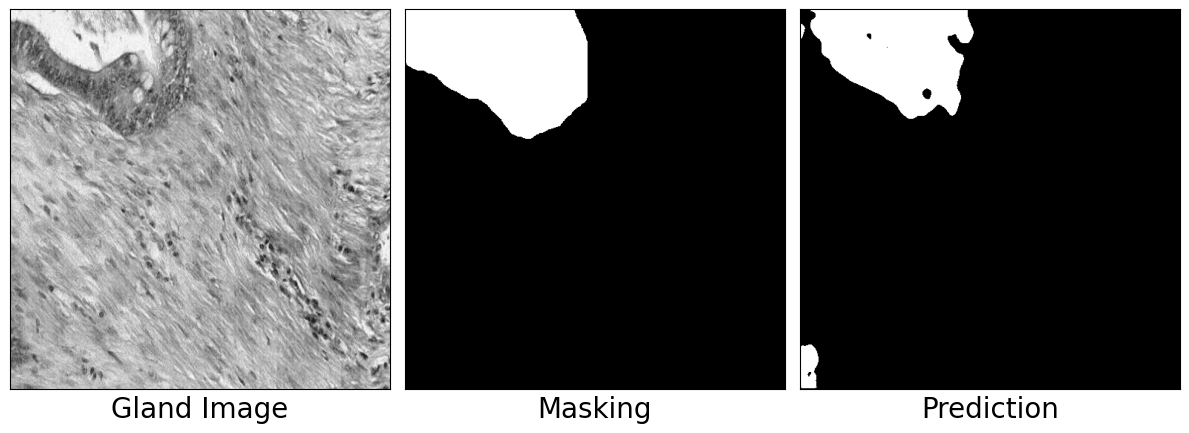

In [22]:
import warnings
import numpy as np
import os
import utils
#import dataloader
import pandas as pd
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter
#import wandb
from tqdm import tqdm
import torch
from torch import nn
import segmentation_models_pytorch as smp
#from torchsummary import summary
import math
import time

warnings.filterwarnings('ignore')
#wandb.init(project='my_Gland_Seg', entity='my_glaseg', config='config.yaml')#config='config/config.yaml')
#config = wandb.config
tabular_data = pd.read_csv(config.csv)
ds_dict = get_split_fold(tabular_data)

patch_size = eval(config.patch_size)
batch_size = config.batch_size
epochs = 10
tr_transforms = get_train_transform(patch_size, prob=config.aug_prob)
train_dl = DataLoader(data=ds_dict['train_ds'], batch_size=batch_size, patch_size=patch_size,
                                 num_threads_in_multithreaded=4, seed_for_shuffle=5243,
                                 return_incomplete=False, shuffle=True, infinite=True)
train_gen = MultiThreadedAugmenter(train_dl, tr_transforms, num_processes=1,
                                   num_cached_per_queue=1,
                                   seeds=None, pin_memory=False)
val_dl = DataLoader(data=ds_dict['testA_ds'], batch_size=batch_size, patch_size=patch_size,
                               num_threads_in_multithreaded=1, seed_for_shuffle=5243,
                               return_incomplete=False, shuffle=True, infinite=True)

# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
# define model
model = smp.Unet(encoder_name=config.encoder_model, decoder_use_batchnorm=True,
                 in_channels=3, classes=config.n_class).to(device)

#checkpoint = '/kaggle/input/osf-gland-seg/loss_200.pth'
checkpoint = False
print(checkpoint)
if checkpoint:
    if os.path.exists(checkpoint):
        print(checkpoint, ' loaded')
        model.load_state_dict(torch.load(checkpoint, weights_only=True, map_location=device))
        model.eval()

# summary(model, (3, 512, 512))
optimizer = eval(config.optimizer)(model.parameters(), lr=float(config.learning_rate))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20,
                                                       factor=0.1)
# xent = nn.BCELoss()
dice_loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
# label smoothing
xent = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.1)


def custom_loss(pred, target):
    xent_l = xent(pred, target)
    dice_l = dice_loss(pred, target)
    loss = xent_l + dice_l
    return loss, xent_l, dice_l


def train(model, optimizer):
    # total number of training batches
    num_batches = math.ceil(len(ds_dict['train_ds']['img_npy'])/batch_size)
    model.train()
    batch_xent_l = []
    batch_dice_l = []
    batch_loss = []
    print("Training...")
    for i in tqdm(range(num_batches)):
        train_batch = next(train_gen)
        imgs = train_batch['data']
        segs = train_batch['seg']
        # normalization
        imgs = utils.min_max_norm(imgs)
        # binarisation
        segs = np.where(segs > 0., 1.0, 0.).astype('float32')
        segs = np.expand_dims(segs[:, 0, :, :], 1)
        imgs, segs = torch.from_numpy(imgs).to(device), torch.from_numpy(segs).to(device)
        # Compute loss
        pred = model(imgs)
        loss, xent_l, dice_l = custom_loss(pred, segs)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # batch losses
        batch_xent_l.append(xent_l)
        batch_dice_l.append(dice_l)
        batch_loss.append(loss)
    # apply sigmoid to masking
    segs = nn.Sigmoid()(segs)
    # taking the average along the batch
    loss = torch.mean(torch.as_tensor(batch_loss)).item()
    avg_xent_l = torch.mean(torch.as_tensor(batch_xent_l)).item()
    avg_dice_l = torch.mean(torch.as_tensor(batch_dice_l)).item()

    return {'loss': loss, 'xent_l': avg_xent_l, 'dice_l': avg_dice_l,
            'imgs': imgs.cpu().detach().numpy(),
            'segs': segs.cpu().detach().numpy(),
            'pred': pred.cpu().detach().numpy()}


def test(model):
    num_batches = math.ceil(len(ds_dict['testA_ds']['img_npy']) / batch_size)
    model.eval()
    # no need back prop for testing set
    batch_xent_l = []
    batch_dice_l = []
    batch_loss = []
    print("Testing...")
    with torch.no_grad():
        #for i in tqdm(range(num_batches)):
        print('num_batches', num_batches)
        for i in range(num_batches):
            val_batch = next(val_dl)
            imgs = val_batch['data']
            segs = val_batch['seg']
            # normalization
            imgs = utils.min_max_norm(imgs)
            # binarisation
            segs = np.where(segs > 0., 1.0, 0.).astype('float32')
            segs = np.expand_dims(segs[:, 0, :, :], 1)
            imgs, segs = torch.from_numpy(imgs).to(device), torch.from_numpy(segs).to(device)
            # Compute loss
            pred = model(imgs)
            loss, xent_l, dice_l = custom_loss(pred, segs)
            # batch losses
            batch_xent_l.append(xent_l)
            batch_dice_l.append(dice_l)
            batch_loss.append(loss)
        # apply sigmoid to masking
        segs = nn.Sigmoid()(segs)
        # taking the average along the batch
        loss = torch.mean(torch.as_tensor(batch_loss)).item()
        avg_xent_l = torch.mean(torch.as_tensor(batch_xent_l)).item()
        avg_dice_l = torch.mean(torch.as_tensor(batch_dice_l)).item()
    return {'loss': loss, 'xent_l': avg_xent_l, 'dice_l': avg_dice_l,
            'imgs': imgs.cpu().detach().numpy(),
            'segs': segs.cpu().detach().numpy(),
            'pred': pred.cpu().detach().numpy()}


start = time.time()

def main():
    current_total_loss = 1000
    current_dice_score = 0
    for e in range(1, epochs+2):
        print("Epcohs:", e)
        train_output = train(model, optimizer)
        test_output = test(model)
        scheduler.step(test_output['loss'])
        print("Training Outputs: ")
        print("Total loss: {:.2f}, BCE: {:.2f}, Dice Score: {:.2f}".format(train_output['loss'], train_output['xent_l'], 1 - train_output['dice_l']))
        print("-"*100)
        print("Validation Outputs: ")
        print("Total loss: {:.2f}, BCE: {:.2f}, Dice Score: {:.2f}".format(test_output['loss'], test_output['xent_l'], 1-test_output['dice_l']))
        # logging
        #wandb.log({"Train_total_loss": train_output['loss'], "Val_total_loss": test_output['loss']}, step=e)
        #wandb.log({"Train_BCE_loss": train_output['xent_l'], "Val_BCE_loss": test_output['xent_l']}, step=e)
        #wandb.log({"Train_dice_score": 1-train_output['dice_l'], "Val_dice_score": 1-test_output['dice_l']}, step=e)
        #wandb.log({"Learning rate": optimizer.param_groups[0]["lr"]}, step=e)
        if e%10==0:
            # threshold sigmoid output with 0.5
            pred_thr = np.where(test_output['pred']>0.5, 1.0, 0.0)
            # sample a dataset from the batch for visualization purpose
            imgs = [test_output['imgs'][0, 0, :, :], test_output['segs'][0, 0, :, :], pred_thr[0, 0, :, :]]
            captions = ['Gland Image', 'Masking', 'Prediction']
            fig = utils.plot_comparison(imgs, captions, plot=False, n_col=len(imgs),
                                  figsize=(12, 12), cmap='gray')
            #wandb.log({"Validation Dataset Output Sample": wandb.Image(fig)}, step=e)

        # save model
        #weights_dir = '/home/kevinteng/Desktop/weights/'
        weights_dir = './weights/'
        if not os.path.exists(weights_dir):
            os.makedirs(weights_dir)
        base_path = os.path.split(weights_dir)[0]
        if test_output['loss'] < current_total_loss:
            current_total_loss = test_output['loss']
            torch.save(model.state_dict(), weights_dir+'best_loss_{}.pth'.format(e))
            #wandb.save(os.path.join(weights_dir, 'best_loss_{}.pth'.format(e)), base_path=base_path)
        if (1-test_output['dice_l']) > current_dice_score:
            current_dice_score = 1-test_output['dice_l']
            torch.save(model.state_dict(), weights_dir+'best_dice_{}.pth'.format(e))
            #wandb.save(os.path.join(weights_dir, 'best_dice_{}.pth'.format(e)), base_path=base_path)
        print()

    print("Model training runtime: {} mins".format((time.time() - start)/60.0))


if __name__ == '__main__':
    main()

In [23]:
torch.save(model.state_dict(), '295_data_mod_res34.pth')
checkpoint
config

MyDynamicallyCreatedDataclass(csv='data.csv', n_class=1, batch_size=2, epochs=250, learning_rate='1e-3', optimizer='torch.optim.Adam', encoder_model='resnet34', patch_size='(512, 512)', aug_prob=0.9)

In [24]:
'''#!ls /kaggle/input/notebook81642cdbb0/OEEM_resources/weights
checkpoint = '/kaggle/input/notebook81642cdbb0/OEEM_resources/weights/res38d.pth'
print(checkpoint)
if checkpoint:
    if os.path.exists(checkpoint):
        print(checkpoint, ' loaded')
        model.load_state_dict(torch.load(checkpoint, weights_only=True, map_location=device))'''

"#!ls /kaggle/input/notebook81642cdbb0/OEEM_resources/weights\ncheckpoint = '/kaggle/input/notebook81642cdbb0/OEEM_resources/weights/res38d.pth'\nprint(checkpoint)\nif checkpoint:\n    if os.path.exists(checkpoint):\n        print(checkpoint, ' loaded')\n        model.load_state_dict(torch.load(checkpoint, weights_only=True, map_location=device))"